<a href="https://colab.research.google.com/github/cbeckler/final_project/blob/cb_etl/PM_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.1.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:13 https://cloud.r-project.

In [2]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2023-01-05 17:54:17--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  6.34MB/s    in 0.2s    

2023-01-05 17:54:17 (6.34 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [3]:
# start spark session that can connect to postgre
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("final-project").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd

cancer_path = "/content/drive/MyDrive/Data/cancer_incidence.csv"

cancer_df = pd.read_csv(cancer_path)

cancer_df.head()

,index,County,FIPS,"Age-Adjusted Incidence Rate(Ê) - cases per 100,000",Lower 95% Confidence Interval,Upper 95% Confidence Interval,Average Annual Count,Recent Trend,Recent 5-Year Trend (ˆ) in Incidence Rates,Lower 95% Confidence Interval.1,Upper 95% Confidence Interval.1
0,0,"US (SEER+NPCR)(1,10)",0,62.4,62.3,62.6,214614,falling,-2.5,-3,-2
1,1,"Autauga County, Alabama(6,10)",1001,74.9,65.1,85.7,43,stable,0.5,-14.9,18.6
2,2,"Baldwin County, Alabama(6,10)",1003,66.9,62.4,71.7,170,stable,3,-10.2,18.3
3,3,"Barbour County, Alabama(6,10)",1005,74.6,61.8,89.4,25,stable,-6.4,-18.3,7.3
4,4,"Bibb County, Alabama(6,10)",1007,86.4,71,104.2,23,stable,-4.5,-31.4,32.9


In [6]:
# get rid of recent trend nulls (stored as *, _, __)

cancer_df = cancer_df.loc[(cancer_df['Recent Trend']=='rising')|(cancer_df['Recent Trend']=='falling')|(cancer_df['Recent Trend']=='stable')]

cancer_df['Recent Trend'].value_counts()

stable     2429
falling     200
rising       43
Name: Recent Trend, dtype: int64

In [7]:
# get pm data

pm_path = "/content/drive/MyDrive/Data/Daily_PM2.5_Concentrations_All_County__2001-2016.csv"

pm_df = pd.read_csv(pm_path)

pm_df.head()

,year,date,statefips,countyfips,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred
0,2001,01JAN2001,1,1,10.664367,10.264546,10.137631,10.188703
1,2001,01JAN2001,1,3,9.803209,8.739505,8.743748,8.811486
2,2001,01JAN2001,1,5,12.087599,11.809159,11.812775,11.802062
3,2001,01JAN2001,1,7,8.579425,8.435394,8.458118,8.448871
4,2001,01JAN2001,1,9,14.399446,13.577741,13.300528,13.231461


In [8]:
# filter pollution data for years matching cancer data
pm_df = pm_df.loc[pm_df['year']<=2014]

In [9]:
# check years
pm_df.year.unique()

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014])

In [10]:
# create state + county FIPS to match cancer data FIPS

pm_df['FIPS'] = pm_df['statefips'].astype(str) + pm_df['countyfips'].astype(str)

pm_df['FIPS'] = pm_df['FIPS'].astype(int)

pm_df.head()

,year,date,statefips,countyfips,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred,FIPS
0,2001,01JAN2001,1,1,10.664367,10.264546,10.137631,10.188703,11
1,2001,01JAN2001,1,3,9.803209,8.739505,8.743748,8.811486,13
2,2001,01JAN2001,1,5,12.087599,11.809159,11.812775,11.802062,15
3,2001,01JAN2001,1,7,8.579425,8.435394,8.458118,8.448871,17
4,2001,01JAN2001,1,9,14.399446,13.577741,13.300528,13.231461,19


In [11]:
# merge cancer and pollution data to get only PM data that matches cancer dataset for EDA analysis

df = pd.merge(cancer_df, pm_df, how='inner', left_on=' FIPS', right_on='FIPS')

df.head()

,index,County,FIPS,"Age-Adjusted Incidence Rate(Ê) - cases per 100,000",Lower 95% Confidence Interval,Upper 95% Confidence Interval,Average Annual Count,Recent Trend,Recent 5-Year Trend (ˆ) in Incidence Rates,Lower 95% Confidence Interval.1,Upper 95% Confidence Interval.1,year,date,statefips,countyfips,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred,FIPS
0,51,"Montgomery County, Alabama(6,10)",1101,61,56.5,65.6,144,falling,-9.6,-15.1,-3.8,2001,01JAN2001,1,101,12.516682,11.825473,11.814210,11.859198,1101
1,51,"Montgomery County, Alabama(6,10)",1101,61,56.5,65.6,144,falling,-9.6,-15.1,-3.8,2001,02JAN2001,1,101,17.072524,16.726676,16.611404,16.656019,1101
2,51,"Montgomery County, Alabama(6,10)",1101,61,56.5,65.6,144,falling,-9.6,-15.1,-3.8,2001,03JAN2001,1,101,14.668316,14.379705,14.331274,14.364346,1101
3,51,"Montgomery County, Alabama(6,10)",1101,61,56.5,65.6,144,falling,-9.6,-15.1,-3.8,2001,04JAN2001,1,101,16.331542,15.844450,15.682546,15.762276,1101
4,51,"Montgomery County, Alabama(6,10)",1101,61,56.5,65.6,144,falling,-9.6,-15.1,-3.8,2001,05JAN2001,1,101,16.514363,15.675695,15.588301,15.666429,1101


In [12]:
# get row count
len(df)

5455571

In [14]:
# get count of unique FIPS
df.FIPS.nunique()

1048

In [16]:
# stats for max pred
pd.options.display.float_format = '{:20,.2f}'.format

df.PM25_max_pred.describe()

count           5,455,571.00
mean                   10.95
std                     5.47
min                     0.21
25%                     7.15
50%                     9.80
75%                    13.47
max                   491.53
Name: PM25_max_pred, dtype: float64

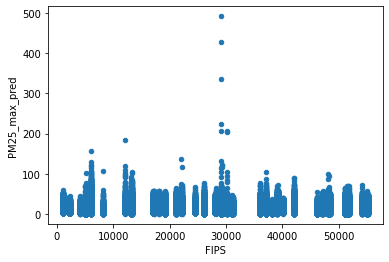

In [25]:
df.plot(x='FIPS', y='PM25_max_pred', kind='scatter')

In [18]:
# stats for med pred
df.PM25_med_pred.describe()

count           5,455,571.00
mean                   10.55
std                     5.24
min                     0.20
25%                     6.89
50%                     9.46
75%                    12.98
max                   335.28
Name: PM25_med_pred, dtype: float64

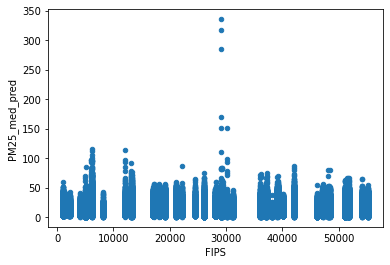

In [26]:
df.plot(x='FIPS', y='PM25_med_pred', kind='scatter')

In [19]:
# stats for mean pred
df.PM25_mean_pred.describe()

count           5,455,571.00
mean                   10.54
std                     5.24
min                     0.20
25%                     6.89
50%                     9.45
75%                    12.97
max                   385.23
Name: PM25_mean_pred, dtype: float64

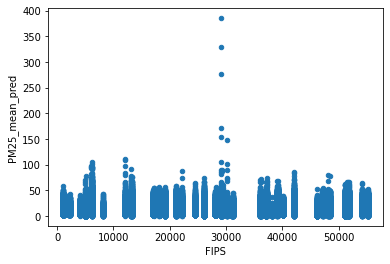

In [27]:
df.plot(x='FIPS', y='PM25_mean_pred', kind='scatter')

In [21]:
# stats for pop pred
df.PM25_pop_pred.describe()

count           5,455,571.00
mean                   10.55
std                     5.24
min                     0.20
25%                     6.89
50%                     9.45
75%                    12.98
max                   382.66
Name: PM25_pop_pred, dtype: float64

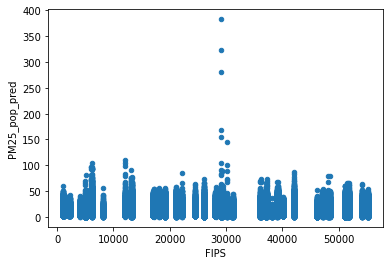

In [28]:
df.plot(x='FIPS', y='PM25_pop_pred', kind='scatter')

In [31]:
# investigate high PM FIPS

hi_df = df[(df['FIPS']>29000)&(df['FIPS']<31000)]

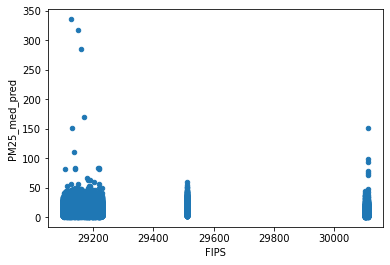

In [32]:
hi_df.plot(x='FIPS', y='PM25_med_pred', kind='scatter')

In [33]:
more_hi_df = hi_df[hi_df['FIPS']<29300]

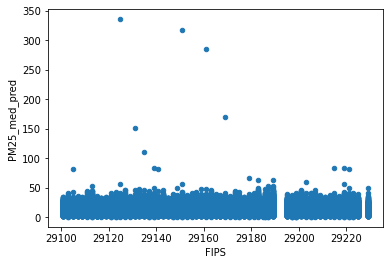

In [41]:
more_hi_df.plot(x='FIPS', y='PM25_med_pred', kind='scatter')

In [44]:
# identify top values

more_hi_df.sort_values('PM25_med_pred', ascending=False)

,index,County,FIPS,"Age-Adjusted Incidence Rate(Ê) - cases per 100,000",Lower 95% Confidence Interval,Upper 95% Confidence Interval,Average Annual Count,Recent Trend,Recent 5-Year Trend (ˆ) in Incidence Rates,Lower 95% Confidence Interval.1,Upper 95% Confidence Interval.1,year,date,statefips,countyfips,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred,FIPS
2628337,1544,"Maries County, Missouri(6,10)",29125,60.4,43,83.6,8,stable,14.9,-6.7,41.6,2001,13SEP2001,29,125,491.53,335.28,385.23,382.66,29125
2694806,1557,"Osage County, Missouri(6,10)",29151,59.6,44.3,78.8,10,stable,-15,-40.6,21.5,2001,13SEP2001,29,151,428.69,316.72,329.52,323.51,29151
2720371,1562,"Phelps County, Missouri(6,10)",29161,71.7,61.5,83.2,36,stable,3.1,-8.7,16.5,2001,13SEP2001,29,161,334.58,284.35,276.45,280.36,29161
2740823,1566,"Pulaski County, Missouri(6,10)",29169,103.4,88.4,120,35,stable,-0.8,-14,14.4,2001,13SEP2001,29,169,224.62,170.00,171.00,168.17,29169
2643676,1547,"Miller County, Missouri(6,10)",29131,88.8,74.5,105.2,28,stable,-6.6,-29.9,24.6,2001,13SEP2001,29,131,205.70,150.96,153.56,155.60,29131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872898,1591,"Washington County, Missouri(6,10)",29221,93,78,110.2,28,stable,-6.2,-23.5,15,2013,03MAY2013,29,221,0.63,0.57,0.56,0.57,29221
2878011,1592,"Wayne County, Missouri(6,10)",29223,114.9,95.3,138.1,25,stable,-3.3,-15.5,10.6,2013,03MAY2013,29,223,0.65,0.56,0.57,0.57,29223
2831994,1583,"Shelby County, Missouri(6,10)",29205,71.9,48.7,103.6,7,stable,-1.6,-20.9,22.6,2013,03MAY2013,29,205,0.59,0.56,0.56,0.56,29205
2663265,1550,"Monroe County, Missouri(6,10)",29137,77.2,56.8,103.4,10,stable,10.1,-28.7,70.1,2013,03MAY2013,29,137,0.56,0.55,0.54,0.55,29137


In [46]:
# sort values of top FIP to see if there are multiple high values

df[df['FIPS']==29125].sort_values('PM25_med_pred', ascending=False)

# there are not--possibly outlier?

,index,County,FIPS,"Age-Adjusted Incidence Rate(Ê) - cases per 100,000",Lower 95% Confidence Interval,Upper 95% Confidence Interval,Average Annual Count,Recent Trend,Recent 5-Year Trend (ˆ) in Incidence Rates,Lower 95% Confidence Interval.1,Upper 95% Confidence Interval.1,year,date,statefips,countyfips,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred,FIPS
2628337,1544,"Maries County, Missouri(6,10)",29125,60.4,43,83.6,8,stable,14.9,-6.7,41.6,2001,13SEP2001,29,125,491.53,335.28,385.23,382.66,29125
2628295,1544,"Maries County, Missouri(6,10)",29125,60.4,43,83.6,8,stable,14.9,-6.7,41.6,2001,02AUG2001,29,125,67.85,56.12,59.32,59.05,29125
2629796,1544,"Maries County, Missouri(6,10)",29125,60.4,43,83.6,8,stable,14.9,-6.7,41.6,2005,11SEP2005,29,125,41.98,41.20,41.11,41.10,29125
2631434,1544,"Maries County, Missouri(6,10)",29125,60.4,43,83.6,8,stable,14.9,-6.7,41.6,2010,07MAR2010,29,125,39.62,39.18,39.11,39.14,29125
2628301,1544,"Maries County, Missouri(6,10)",29125,60.4,43,83.6,8,stable,14.9,-6.7,41.6,2001,08AUG2001,29,125,40.38,38.28,38.49,38.39,29125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632948,1544,"Maries County, Missouri(6,10)",29125,60.4,43,83.6,8,stable,14.9,-6.7,41.6,2014,29APR2014,29,125,2.18,2.16,2.16,2.16,29125
2628348,1544,"Maries County, Missouri(6,10)",29125,60.4,43,83.6,8,stable,14.9,-6.7,41.6,2001,24SEP2001,29,125,2.10,2.08,2.06,2.06,29125
2632743,1544,"Maries County, Missouri(6,10)",29125,60.4,43,83.6,8,stable,14.9,-6.7,41.6,2013,06OCT2013,29,125,1.94,1.94,1.92,1.92,29125
2633116,1544,"Maries County, Missouri(6,10)",29125,60.4,43,83.6,8,stable,14.9,-6.7,41.6,2014,14OCT2014,29,125,1.52,1.48,1.37,1.37,29125


In [51]:
# sort the values of the high FIP by the month to see if the spike is sudden
df[(df['FIPS']==29125)&(df['date'].str.contains('SEP2001'))]
# it is--possibly an outlier??

,index,County,FIPS,"Age-Adjusted Incidence Rate(Ê) - cases per 100,000",Lower 95% Confidence Interval,Upper 95% Confidence Interval,Average Annual Count,Recent Trend,Recent 5-Year Trend (ˆ) in Incidence Rates,Lower 95% Confidence Interval.1,Upper 95% Confidence Interval.1,year,date,statefips,countyfips,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred,FIPS
2628325,1544,"Maries County, Missouri(6,10)",29125,60.4,43,83.6,8,stable,14.9,-6.7,41.6,2001,01SEP2001,29,125,10.78,10.30,10.44,10.44,29125
2628326,1544,"Maries County, Missouri(6,10)",29125,60.4,43,83.6,8,stable,14.9,-6.7,41.6,2001,02SEP2001,29,125,11.50,10.96,10.97,10.94,29125
2628327,1544,"Maries County, Missouri(6,10)",29125,60.4,43,83.6,8,stable,14.9,-6.7,41.6,2001,03SEP2001,29,125,14.02,13.42,13.52,13.52,29125
2628328,1544,"Maries County, Missouri(6,10)",29125,60.4,43,83.6,8,stable,14.9,-6.7,41.6,2001,04SEP2001,29,125,13.57,12.61,12.82,12.79,29125
2628329,1544,"Maries County, Missouri(6,10)",29125,60.4,43,83.6,8,stable,14.9,-6.7,41.6,2001,05SEP2001,29,125,22.08,21.24,21.40,21.46,29125
2628330,1544,"Maries County, Missouri(6,10)",29125,60.4,43,83.6,8,stable,14.9,-6.7,41.6,2001,06SEP2001,29,125,13.46,13.01,13.11,13.09,29125
2628331,1544,"Maries County, Missouri(6,10)",29125,60.4,43,83.6,8,stable,14.9,-6.7,41.6,2001,07SEP2001,29,125,34.32,26.97,29.31,29.19,29125
2628332,1544,"Maries County, Missouri(6,10)",29125,60.4,43,83.6,8,stable,14.9,-6.7,41.6,2001,08SEP2001,29,125,4.75,4.75,4.74,4.74,29125
2628333,1544,"Maries County, Missouri(6,10)",29125,60.4,43,83.6,8,stable,14.9,-6.7,41.6,2001,09SEP2001,29,125,4.54,4.53,4.46,4.44,29125
2628334,1544,"Maries County, Missouri(6,10)",29125,60.4,43,83.6,8,stable,14.9,-6.7,41.6,2001,10SEP2001,29,125,18.02,15.01,15.96,15.91,29125


In [ ]:
https://aaqr.org/articles/aaqr-20-05-oa-0217

# the study linked above talks about variability in PM measurements
## based on both their findings and my exploratory analysis, it might be worthwhile to remove measurements >100 as outliers